# Import and organize the data

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
from pymc3.gp.util import plot_gp_dist

# changing default font sizes and family
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Cambria' #'serif' Cambria, Times New Roman, Georgia

SN = pd.read_csv('data/LSQ12gdj_photometry.csv')
SN

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
0,LSQ12gdj,56237.50000,18.300,NaN,F,NaN,NaN,NaN,"2012ATel.4566....1C,Latest Supernovae"
1,LSQ12gdj,56242.05339,17.487,0.012,F,i,QUEST,ESO Schmidt,2015ApJS..219...13W
2,LSQ12gdj,56242.05846,17.184,0.008,F,r,QUEST,ESO Schmidt,2015ApJS..219...13W
3,LSQ12gdj,56242.06586,17.037,0.008,F,V,QUEST,ESO Schmidt,2015ApJS..219...13W
4,LSQ12gdj,56242.07164,17.006,0.009,F,B,QUEST,ESO Schmidt,2015ApJS..219...13W
...,...,...,...,...,...,...,...,...,...
599,LSQ12gdj,56679.76200,19.351,NaN,T,U,UVOT,Swift,2014Ap&SS.354...89B
600,LSQ12gdj,56679.76270,19.717,NaN,T,B,UVOT,Swift,2014Ap&SS.354...89B
601,LSQ12gdj,56679.76460,20.389,NaN,T,UVW2,UVOT,Swift,2014Ap&SS.354...89B
602,LSQ12gdj,56679.76620,18.782,NaN,T,V,UVOT,Swift,2014Ap&SS.354...89B


In [2]:
time = SN['time']
mag = SN['magnitude']
error = SN['e_magnitude']

UVW2band = np.where(SN['band'] == 'UVW2')[0]
UVM2band = np.where(SN['band'] == 'UVM2')[0]
UVW1band = np.where(SN['band'] == 'UVW1')[0]
Uband = np.where(SN['band'] == 'U')[0]
Bband = np.where(SN['band'] == 'B')[0]
Vband = np.where(SN['band'] == 'V')[0]
Gband = np.where(SN['band'] == 'G')[0]
Rband = np.where(SN['band'] == 'R')[0]
rband = np.where(SN['band'] == 'r')[0]
Iband = np.where(SN['band'] == 'I')[0]
iband = np.where(SN['band'] == 'i')[0]
Zband = np.where(SN['band'] == 'Z')[0]

# get rid of the last weird point really far out in time
UVW2band = UVW2band[:-1]
UVM2band = UVM2band[:-1]
UVW1band = UVW1band[:-1]
Uband = Uband[:-1]
Bband = Bband[:-1]
Vband = Vband[:-1]
Gband = Gband[:-1]
Rband = Rband[:-1]
rband = rband[:-1]
Iband = Iband[:-1]
iband = iband[:-1]
Zband = Zband[:-1]

band_idxs = [UVW2band, UVM2band, UVW1band, Uband, Bband, Vband, Gband, Rband, rband, Iband, iband, Zband]
labels = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V', 'G', 'R', 'r', 'I', 'i', 'Z']

print('Number of points: ', len(SN['band']))
print('Sum of points in bands excluding 1 NaN: ', len(iband)+len(rband)+len(Vband)+len(Bband)+
      len(Uband)+len(Zband)+len(Gband)+len(Iband)+len(UVW1band)+len(UVW2band)+len(UVM2band)+len(Rband))

time = time - min(time)

Number of points:  604
Sum of points in bands excluding 1 NaN:  591


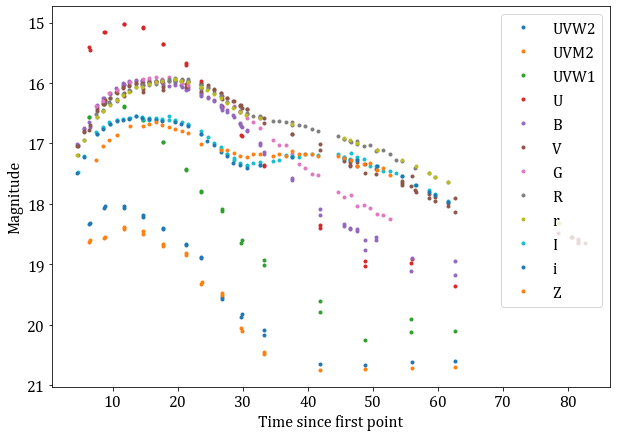

In [3]:
fig = plt.figure(figsize=(10, 7))
for idx, val in enumerate(band_idxs):
    plt.plot(time[val], mag[val], 'o', ms=3, label=labels[idx])
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# Get initial parameters using np.polyfit

In [4]:
use_band, band_str = Uband, 'U'
time_band = np.asarray(time[use_band])
mag_band = np.asarray(mag[use_band])
error_band = np.asarray(error[use_band])

days_after_peak = 15
peakbright_idx = np.argmin(mag_band)
turn = peakbright_idx + days_after_peak
rise_mag = np.asarray(mag_band)[:turn]
decline_mag = np.asarray(mag_band)[turn:]
rise_time = np.asarray(time_band)[:turn]
decline_time = np.asarray(time_band)[turn:]

rise_coeff = np.polyfit(rise_time, rise_mag, 2)
decline_coeff = np.polyfit(decline_time, decline_mag, 2)

p0 = [*rise_coeff, *decline_coeff, time_band[turn]]
print('Initial parameters: ', p0)

print(time_band[turn])

Initial parameters:  [0.005051697844179434, -0.11633578259689434, 15.82436561400451, -0.002313859324904561, 0.28191808752895064, 10.609723606139095, 33.30000000000291]
33.30000000000291


# Make the mean model and show example of using it

In [5]:
class MagModel(pm.gp.mean.Mean):
    def __init__(self, r0, r1, r2, d0, d1, d2):
        self.r0 = r0
        self.r1 = r1
        self.r2 = r2
        self.d0 = d0
        self.d1 = d1
        self.d2 = d2
    def __call__(self, t):
        rise_time = t[t <= 30.6]
        decline_time = t[t > 30.6]
        rise_mag = self.r0*rise_time**2 + self.r1*rise_time + self.r2
        decline_mag = self.d0*decline_time**2 + self.d1*decline_time + self.d2
        mag_arr = tt.concatenate([rise_mag, decline_mag])
        return mag_arr

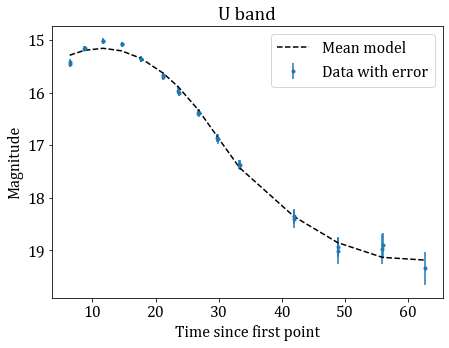

In [6]:
rise_time = time_band[time_band <= 30.6]
decline_time = time_band[time_band > 30.6]
rise_mag = p0[0]*rise_time**2 + p0[1]*rise_time + p0[2]
decline_mag = p0[3]*decline_time**2 + p0[4]*decline_time + p0[5]
mag_fit = np.concatenate([rise_mag, decline_mag])

fig = plt.figure(figsize=(7,5))
plt.errorbar(x=time_band, y=mag_band, yerr=error_band, fmt='.', label='Data with error')
#plt.errorbar(x=time_band, y=mag_band, yerr=error_band, fmt='.', label='Data with error')
plt.plot(time_band, mag_fit, 'k--', label='Mean model')
plt.legend()
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.title('{} band'.format(band_str))
plt.gca().invert_yaxis()

# Initialize pymc3 GP for single band

In [7]:
with pm.Model() as marginal_gp_model:
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=10.0)
    
    r0 = pm.Normal('r0', p0[0], sigma=p0[0]*1e-1, shape=1)
    r1 = pm.Normal('r1', p0[1], sigma=p0[1]*1e-1, shape=1)
    r2 = pm.Normal('r2', p0[2], sigma=p0[2]*1e-1, shape=1)
    d0 = pm.Normal('d0', p0[3], sigma=p0[3]*1e-1, shape=1)
    d1 = pm.Normal('d1', p0[4], sigma=p0[4]*1e-1, shape=1)
    d2 = pm.Normal('d2', p0[5], sigma=p0[5]*1e-1, shape=1)
    #turn = pm.Normal('turn', p0[6], sigma=1, shape=1)

    mean_func = MagModel(r0=r0, r1=r1, r2=r2, d0=d0, d1=d1, d2=d2)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    y_ = gp.marginal_likelihood("mag", X=time_band[:, None], y=mag_band, noise=0.1)
    mp = pm.find_MAP()

/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

In [8]:
# new values from x=0 to x=100
X_new = np.linspace(0, 70, 600)[:, None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=50)

/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/50 [00:00<?, ?it/s]/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inste

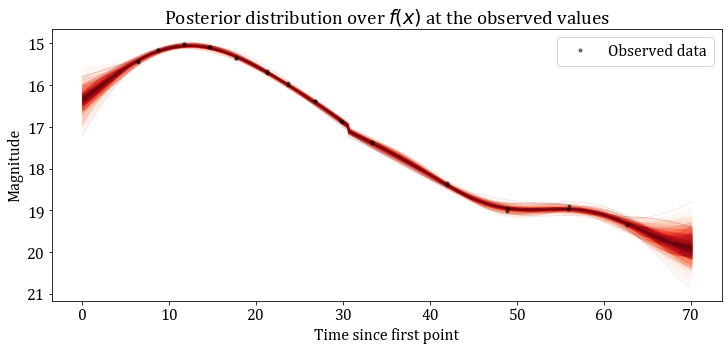

In [9]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)
plt.plot(time_band, mag_band, 'ok', ms=3, alpha=0.5, label="Observed data")
plt.gca().invert_yaxis()
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.title('Posterior distribution over $f(x)$ at the observed values')
plt.legend()

# Hierarchical model using pymc3

In [10]:
time_cut = np.asarray(time[:-6])
mag_cut = np.asarray(mag[:-6])
error_cut = np.asarray(error[:-6])
X_new = np.linspace(0, 70, 600)[:, None]

with pm.Model() as hierarchical_model: 
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=10.0)
    
    r0 = pm.Normal('r0', p0[0], sigma=p0[0]*1e-1, shape=len(band_idxs))
    r1 = pm.Normal('r1', p0[1], sigma=p0[1]*1e-1, shape=len(band_idxs))
    r2 = pm.Normal('r2', p0[2], sigma=p0[2]*1e-1, shape=len(band_idxs))
    d0 = pm.Normal('d0', p0[3], sigma=p0[3]*1e-1, shape=len(band_idxs))
    d1 = pm.Normal('d1', p0[4], sigma=p0[4]*1e-1, shape=len(band_idxs))
    d2 = pm.Normal('d2', p0[5], sigma=p0[5]*1e-1, shape=len(band_idxs))

    mean_func0 = MagModel(r0=r0[0], r1=r1[0], r2=r2[0], d0=d0[0], d1=d1[0], d2=d2[0])
    gp0 = pm.gp.Marginal(mean_func=mean_func0, cov_func=cov_func)
    y0_ = gp0.marginal_likelihood('mag0', X=time_cut[UVW2band][:, None], y=mag_cut[UVW2band], noise=0.1)
    mp0 = pm.find_MAP()
    
    mean_func1 = MagModel(r0=r0[1], r1=r1[1], r2=r2[1], d0=d0[1], d1=d1[1], d2=d2[1])
    gp1 = pm.gp.Marginal(mean_func=mean_func1, cov_func=cov_func)
    y1_ = gp1.marginal_likelihood('mag1', X=time_cut[UVM2band][:, None], y=mag_cut[UVM2band], noise=0.1)
    mp1 = pm.find_MAP()
    
    mean_func2 = MagModel(r0=r0[2], r1=r1[2], r2=r2[2], d0=d0[2], d1=d1[2], d2=d2[2])
    gp2 = pm.gp.Marginal(mean_func=mean_func2, cov_func=cov_func)
    y2_ = gp2.marginal_likelihood('mag2', X=time_cut[UVW1band][:, None], y=mag_cut[UVW1band], noise=0.1)
    mp2 = pm.find_MAP()
    
    mean_func3 = MagModel(r0=r0[3], r1=r1[3], r2=r2[3], d0=d0[3], d1=d1[3], d2=d2[3])
    gp3 = pm.gp.Marginal(mean_func=mean_func3, cov_func=cov_func)
    y3_ = gp3.marginal_likelihood('mag3', X=time_cut[Uband][:, None], y=mag_cut[Uband], noise=0.1)
    mp3 = pm.find_MAP()
    
    mean_func4 = MagModel(r0=r0[4], r1=r1[4], r2=r2[4], d0=d0[4], d1=d1[4], d2=d2[4])
    gp4 = pm.gp.Marginal(mean_func=mean_func4, cov_func=cov_func)
    y4_ = gp4.marginal_likelihood('mag4', X=time_cut[Bband][:, None], y=mag_cut[Bband], noise=0.1)
    mp4 = pm.find_MAP()
    
    mean_func5 = MagModel(r0=r0[5], r1=r1[5], r2=r2[5], d0=d0[5], d1=d1[5], d2=d2[5])
    gp5 = pm.gp.Marginal(mean_func=mean_func5, cov_func=cov_func)
    y5_ = gp5.marginal_likelihood('mag5', X=time_cut[Vband][:, None], y=mag_cut[Vband], noise=0.1)
    mp5 = pm.find_MAP()
        
    mean_func6 = MagModel(r0=r0[6], r1=r1[6], r2=r2[6], d0=d0[6], d1=d1[6], d2=d2[6])
    gp6 = pm.gp.Marginal(mean_func=mean_func6, cov_func=cov_func)
    y6_ = gp6.marginal_likelihood('mag6', X=time_cut[Gband][:, None], y=mag_cut[Gband], noise=0.1)
    mp6 = pm.find_MAP()
    
    mean_func7 = MagModel(r0=r0[7], r1=r1[7], r2=r2[7], d0=d0[7], d1=d1[7], d2=d2[7])
    gp7 = pm.gp.Marginal(mean_func=mean_func7, cov_func=cov_func)
    y7_ = gp7.marginal_likelihood('mag7', X=time_cut[Rband][:, None], y=mag_cut[Rband], noise=0.1)
    mp7 = pm.find_MAP()
    
    mean_func8 = MagModel(r0=r0[8], r1=r1[8], r2=r2[8], d0=d0[8], d1=d1[8], d2=d2[8])
    gp8 = pm.gp.Marginal(mean_func=mean_func8, cov_func=cov_func)
    y8_ = gp8.marginal_likelihood('mag8', X=time_cut[rband][:, None], y=mag_cut[rband], noise=0.1)
    mp8 = pm.find_MAP()
    
    mean_func9 = MagModel(r0=r0[9], r1=r1[9], r2=r2[9], d0=d0[9], d1=d1[9], d2=d2[9])
    gp9 = pm.gp.Marginal(mean_func=mean_func9, cov_func=cov_func)
    y9_ = gp9.marginal_likelihood('mag9', X=time_cut[Iband][:, None], y=mag_cut[Iband], noise=0.1)
    mp9 = pm.find_MAP()
    
    mean_func10 = MagModel(r0=r0[10], r1=r1[10], r2=r2[10], d0=d0[10], d1=d1[10], d2=d2[10])
    gp10 = pm.gp.Marginal(mean_func=mean_func10, cov_func=cov_func)
    y10_ = gp10.marginal_likelihood('mag10', X=time_cut[iband][:, None], y=mag_cut[iband], noise=0.1)
    mp10 = pm.find_MAP()
    
    mean_func11 = MagModel(r0=r0[11], r1=r1[11], r2=r2[11], d0=d0[11], d1=d1[11], d2=d2[11])
    gp11 = pm.gp.Marginal(mean_func=mean_func11, cov_func=cov_func)
    y11_ = gp11.marginal_likelihood('mag11', X=time_cut[Zband][:, None], y=mag_cut[Zband], noise=0.1)
    mp11 = pm.find_MAP()

[[ 6.4   ]
 [ 6.4339]
 [ 8.7   ]
 [ 8.748 ]
 [11.6795]
 [11.7   ]
 [14.6   ]
 [14.6215]
 [17.6579]
 [17.7   ]
 [21.1988]
 [21.2   ]
 [23.6   ]
 [23.6405]
 [26.7745]
 [26.8   ]
 [29.7813]
 [29.8   ]
 [33.268 ]
 [33.3   ]
 [41.9025]
 [48.8288]
 [55.9283]
 [62.6109]]


/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -inf, ||grad|| = 11,408: 100%|██████████| 4/4 [00:00<00:00, 450.87it/s]
/opt/miniconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing i

In [11]:
# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred0 = gp0.conditional("f_pred0", X_new)
    f_pred1 = gp1.conditional("f_pred1", X_new)
    f_pred2 = gp2.conditional("f_pred2", X_new)
    f_pred3 = gp3.conditional("f_pred3", X_new)
    f_pred4 = gp4.conditional("f_pred4", X_new)
    f_pred5 = gp5.conditional("f_pred5", X_new)
    f_pred6 = gp6.conditional("f_pred6", X_new)
    f_pred7 = gp7.conditional("f_pred7", X_new)
    f_pred8 = gp8.conditional("f_pred8", X_new)
    f_pred9 = gp9.conditional("f_pred9", X_new)
    f_pred10 = gp10.conditional("f_pred10", X_new)
    f_pred11 = gp11.conditional("f_pred11", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples0 = pm.sample_posterior_predictive([mp0], vars=[f_pred0], samples=50)
    pred_samples1 = pm.sample_posterior_predictive([mp1], vars=[f_pred1], samples=50)
    pred_samples2 = pm.sample_posterior_predictive([mp2], vars=[f_pred2], samples=50)
    pred_samples3 = pm.sample_posterior_predictive([mp3], vars=[f_pred3], samples=50)
    pred_samples4 = pm.sample_posterior_predictive([mp4], vars=[f_pred4], samples=50)
    pred_samples5 = pm.sample_posterior_predictive([mp5], vars=[f_pred5], samples=50)
    pred_samples6 = pm.sample_posterior_predictive([mp6], vars=[f_pred6], samples=50)
    pred_samples7 = pm.sample_posterior_predictive([mp7], vars=[f_pred7], samples=50)
    pred_samples8 = pm.sample_posterior_predictive([mp8], vars=[f_pred8], samples=50)
    pred_samples9 = pm.sample_posterior_predictive([mp9], vars=[f_pred9], samples=50)
    pred_samples10 = pm.sample_posterior_predictive([mp10], vars=[f_pred10], samples=50)
    pred_samples11 = pm.sample_posterior_predictive([mp11], vars=[f_pred11], samples=50)

100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


/opt/miniconda3/envs/fds/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


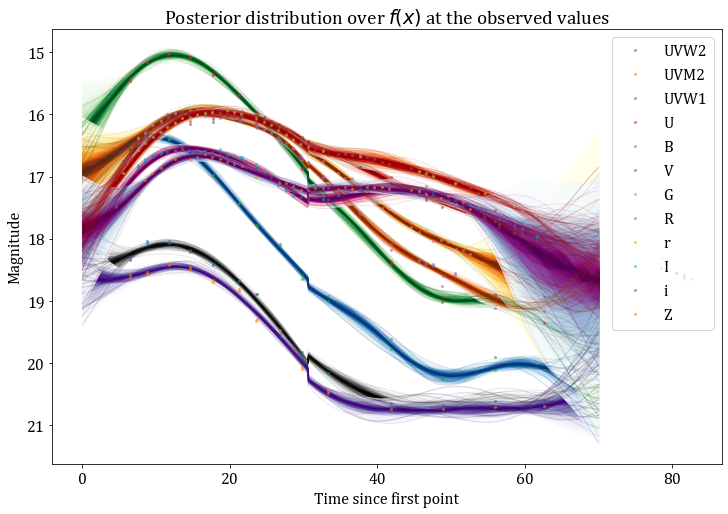

In [13]:
# plot the results
band_idxs = [UVW2band, UVM2band, UVW1band, Uband, Bband, Vband, Gband, Rband, rband, Iband, iband, Zband]

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
plot_gp_dist(ax, pred_samples0["f_pred0"], X_new, palette = 'Greys')
plt.plot(time_cut[UVW2band], mag_cut[UVW2band], 'o', ms=2, alpha=0.5, label="UVW2")
plot_gp_dist(ax, pred_samples1["f_pred1"], X_new, palette = 'Purples')
plt.plot(time_cut[UVM2band], mag_cut[UVM2band], 'o', ms=2, alpha=0.5, label="UVM2")
plot_gp_dist(ax, pred_samples2["f_pred2"], X_new, palette = 'Blues')
plt.plot(time_cut[UVW1band], mag_cut[UVW1band], 'o', ms=2, alpha=0.5, label="UVW1")
plot_gp_dist(ax, pred_samples3["f_pred3"], X_new, palette = 'Greens')
plt.plot(time_cut[Uband], mag_cut[Uband], 'o', ms=2, alpha=0.5, label="U")
plot_gp_dist(ax, pred_samples4["f_pred4"], X_new, palette = 'Oranges')
plt.plot(time_cut[Bband], mag_cut[Bband], 'o', ms=2, alpha=0.5, label="B")
plot_gp_dist(ax, pred_samples5["f_pred5"], X_new, palette = 'Reds')
plt.plot(time_cut[Vband], mag_cut[Vband], 'o', ms=2, alpha=0.5, label="V")
plot_gp_dist(ax, pred_samples6["f_pred6"], X_new, palette = 'YlOrBr')
plt.plot(time_cut[Gband], mag_cut[Gband], 'o', ms=2, alpha=0.5, label="G")
plot_gp_dist(ax, pred_samples7["f_pred7"], X_new, palette = 'YlOrRd')
plt.plot(time_cut[Rband], mag_cut[Rband], 'o', ms=2, alpha=0.5, label="R")
plot_gp_dist(ax, pred_samples8["f_pred8"], X_new, palette = 'OrRd')
plt.plot(time_cut[rband], mag_cut[rband], 'o', ms=2, alpha=0.5, label="r")
plot_gp_dist(ax, pred_samples9["f_pred9"], X_new, palette = 'PuRd')
plt.plot(time_cut[Iband], mag_cut[Iband], 'o', ms=2, alpha=0.5, label="I")
plot_gp_dist(ax, pred_samples10["f_pred10"], X_new, palette = 'RdPu')
plt.plot(time_cut[iband], mag_cut[iband], 'o', ms=2, alpha=0.5, label="i")
plot_gp_dist(ax, pred_samples11["f_pred11"], X_new, palette = 'BuPu')
plt.plot(time_cut[Zband], mag_cut[Zband], 'o', ms=2, alpha=0.5, label="Z")
plt.gca().invert_yaxis()
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.title('Posterior distribution over $f(x)$ at the observed values')
plt.legend()

# Get flux from magnitudes found using median posterior predictions

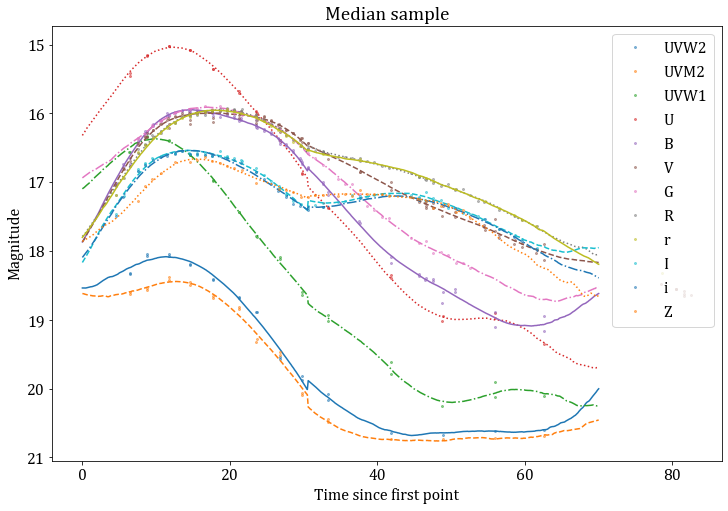

In [24]:
med0 = np.median(pred_samples0['f_pred0'], axis=0)
med1 = np.median(pred_samples1['f_pred1'], axis=0)
med2 = np.median(pred_samples2['f_pred2'], axis=0)
med3 = np.median(pred_samples3['f_pred3'], axis=0)
med4 = np.median(pred_samples4['f_pred4'], axis=0)
med5 = np.median(pred_samples5['f_pred5'], axis=0)
med6 = np.median(pred_samples6['f_pred6'], axis=0)
med7 = np.median(pred_samples7['f_pred7'], axis=0)
med8 = np.median(pred_samples8['f_pred8'], axis=0)
med9 = np.median(pred_samples9['f_pred9'], axis=0)
med10 = np.median(pred_samples10['f_pred10'], axis=0)
med11 = np.median(pred_samples11['f_pred11'], axis=0)

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
plt.plot(X_new, med0, 'C0-')
plt.plot(time_cut[UVW2band], mag_cut[UVW2band], 'C0o', ms=2, alpha=0.5, label="UVW2")
plt.plot(X_new, med1, 'C1--')
plt.plot(time_cut[UVM2band], mag_cut[UVM2band], 'C1o', ms=2, alpha=0.5, label="UVM2")
plt.plot(X_new, med2, 'C2-.')
plt.plot(time_cut[UVW1band], mag_cut[UVW1band], 'C2o', ms=2, alpha=0.5, label="UVW1")
plt.plot(X_new, med3, 'C3:')
plt.plot(time_cut[Uband], mag_cut[Uband], 'C3o', ms=2, alpha=0.5, label="U")
plt.plot(X_new, med4, 'C4-')
plt.plot(time_cut[Bband], mag_cut[Bband], 'C4o', ms=2, alpha=0.5, label="B")
plt.plot(X_new, med5, 'C5--')
plt.plot(time_cut[Vband], mag_cut[Vband], 'C5o', ms=2, alpha=0.5, label="V")
plt.plot(X_new, med6, 'C6-.')
plt.plot(time_cut[Gband], mag_cut[Gband], 'C6o', ms=2, alpha=0.5, label="G")
plt.plot(X_new, med7, 'C7:')
plt.plot(time_cut[Rband], mag_cut[Rband], 'C7o', ms=2, alpha=0.5, label="R")
plt.plot(X_new, med8, 'C8-')
plt.plot(time_cut[rband], mag_cut[rband], 'C8o', ms=2, alpha=0.5, label="r")
plt.plot(X_new, med9, 'C9--')
plt.plot(time_cut[Iband], mag_cut[Iband], 'C9o', ms=2, alpha=0.5, label="I")
plt.plot(X_new, med10, 'C0-.')
plt.plot(time_cut[iband], mag_cut[iband], 'C0o', ms=2, alpha=0.5, label="i")
plt.plot(X_new, med11, 'C1:')
plt.plot(time_cut[Zband], mag_cut[Zband], 'C1o', ms=2, alpha=0.5, label="Z")
plt.gca().invert_yaxis()
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.title('Median sample')
plt.legend()

In [ ]:
def convert_mag_flux():